# Compare deepcoadds and Objects

 work with Weakly_2022_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/23
- update : 2023/12/29


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import pprint

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Butler repo and collection

In [9]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Give the collection

In [10]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

### input files

- object file
- tract and patch

In [11]:
file_obs = "objectTable_202312.csv"
file_tractpatch = "Latiss_tractspatchs.pickle"

### DataId

- Tract 5615, patch 294 ou 313
- tract 5634, patch 72,73, 91, 92

In [12]:
tract = 5634
patch = 92
band = 'r'
skymap = 'latiss_v1'

In [13]:
the_dataId = {'skymap':skymap,'band': band, 'tract': tract, 'patch': patch}

In [14]:
the_title = f"Auxtel deepCoadd : band={band}, tract={tract}, patch={patch}" 

## Init

In [15]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [16]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

In [17]:
df = pd.read_csv(file_obs,index_col=0) 

In [18]:
selection1 =  (df["tract"] == tract) & (df["patch"] == patch)
selection2 = df["refExtendedness"] == False
selection3 = df["detect_isPrimary"] == True

In [19]:
df_sel = df[selection1 & selection2 & selection3]

In [20]:
df_sel["g_cModelMag"] = df_sel["g_cModelFlux"].map(convert_fluxtomag)
df_sel["r_cModelMag"] = df_sel["r_cModelFlux"].map(convert_fluxtomag)
df_sel["i_cModelMag"] = df_sel["i_cModelFlux"].map(convert_fluxtomag)

/tmp/ipykernel_61601/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_61601/2033226273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["g_cModelMag"] = df_sel["g_cModelFlux"].map(convert_fluxtomag)
/tmp/ipykernel_61601/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_61601/2033226273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["r_cModelMag"] 

## Plot magnitudes No Selection cut

Text(0.5, 0.98, 'Auxtel deepCoadd : band=r, tract=5634, patch=92')

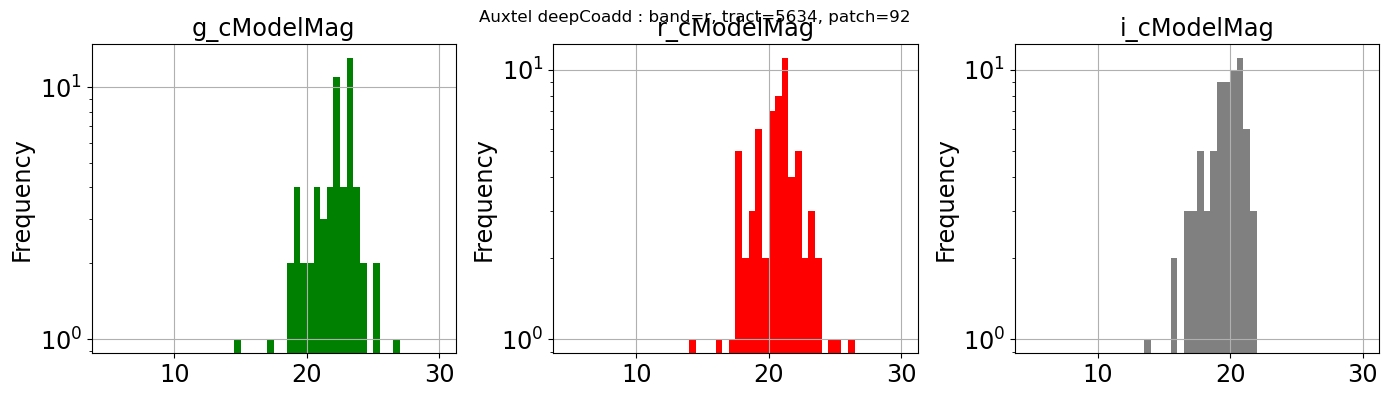

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="g_cModelMag",ax=ax1)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="r_cModelMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="i_cModelMag",ax=ax3)
plt.tight_layout()
plt.suptitle(the_title)

### Plot deep Coadds without selection

In [22]:
pos_obj = df_sel[["x","y","g_ra","r_ra","i_ra", "g_dec","r_dec","i_dec" ]]
pos_obj

,x,y,g_ra,r_ra,i_ra,g_dec,r_dec,i_dec
objectId,,,,,,,,
2236369267501039632,48033.863971,12024.636137,270.212101,270.212101,270.212105,-25.001858,-25.001858,-25.001868
2236369267501039635,48654.577005,12098.913595,270.193080,270.193090,270.193093,-24.999725,-24.999728,-24.999727
2236369267501039637,50556.454085,12253.647982,270.134848,270.134834,270.134834,-24.995168,-24.995178,-24.995178
2236369267501039640,50767.229995,12315.879308,270.128391,270.128391,270.128384,-24.993417,-24.993420,-24.993420
2236369267501039645,50743.436235,12380.785994,270.129137,270.129139,270.129123,-24.991615,-24.991607,-24.991621
...,...,...,...,...,...,...,...,...
2236369267501040311,50342.569124,14893.253217,270.141767,270.141778,270.141780,-24.921901,-24.921887,-24.921894
2236369267501040312,50385.456464,14664.947737,270.140447,270.140428,270.140433,-24.928228,-24.928225,-24.928229
2236369267501040313,50396.575904,14834.133010,270.140105,270.140107,270.140118,-24.923532,-24.923531,-24.923528


In [23]:
my_deepCoadd = butler.get('deepCoadd', dataId=the_dataId,collections=my_collection)
my_deepCoadd_inputs = butler.get("deepCoadd.coaddInputs",the_dataId,collections=my_collection)   

In [24]:
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
2023052300626,47800,11800,51199,15199,1294168,0.03186965188253922,SDSSr_65mm~empty
2023052300632,47800,11800,51199,15199,1206589,0.03627710017334731,SDSSr_65mm~empty
2023052300645,47800,11800,51199,15199,939370,0.013274168176176477,SDSSr_65mm~empty
2023052400660,47800,11800,51199,15199,1455476,0.04438177571579836,SDSSr_65mm~empty
2023052400665,47800,11800,51199,15199,1119482,0.043525143474772585,SDSSr_65mm~empty
2023052400666,47800,11800,51199,15199,780247,0.045125692336936994,SDSSr_65mm~empty
2023052400678,47800,11800,51199,15199,447011,0.049880671862606134,SDSSr_65mm~empty
2023052400684,47800,11800,51199,15199,4843121,0.042651374429548396,SDSSr_65mm~empty


(47799.5, 51199.5, 11799.5, 15199.5)

<Figure size 600x600 with 0 Axes>

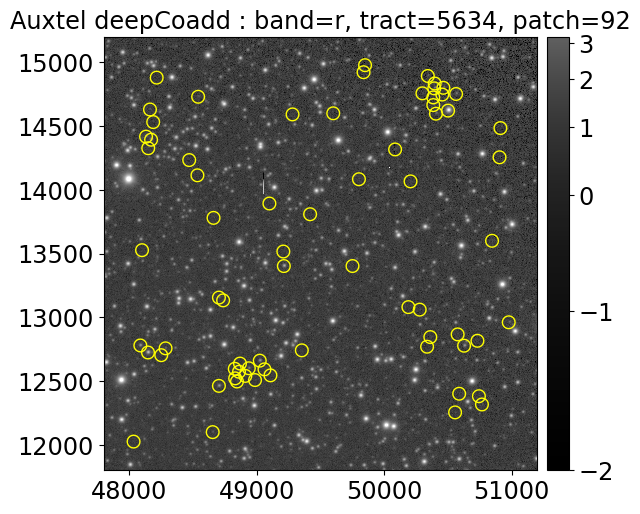

In [25]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image,title=the_title )

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')

plt.gca().axis('on')

#plt.scatter(pos_obj.x.values,pos_obj.y.values,marker="o",color="y")

## Plot magnitude by applying Selection cut

In [26]:
selection4 = df_sel["r_cModelMag"] < 16.0
df_sel = df_sel[selection4]

Text(0.5, 0.98, 'Auxtel deepCoadd : band=r, tract=5634, patch=92')

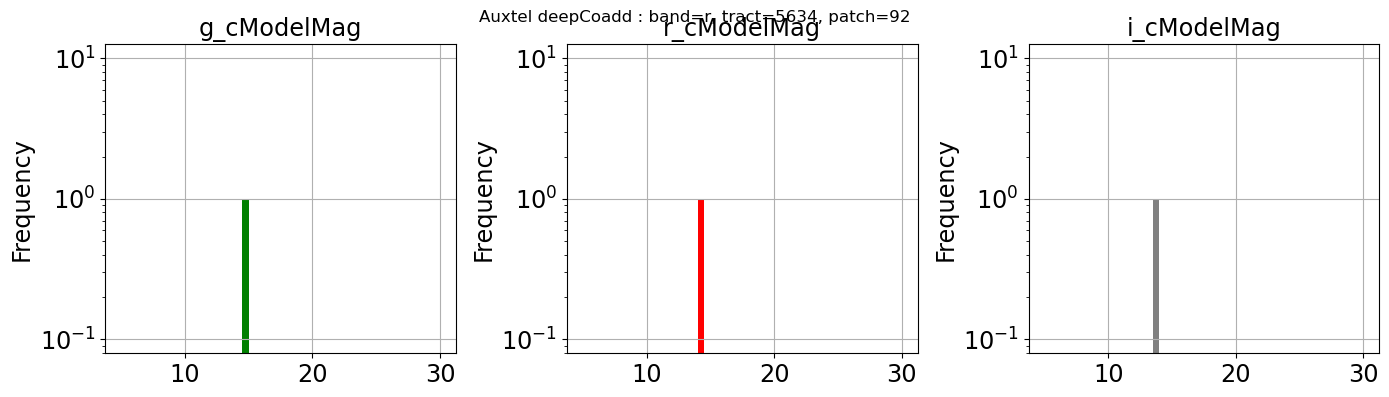

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="g_cModelMag",ax=ax1)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="r_cModelMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="i_cModelMag",ax=ax3)
plt.tight_layout()
plt.suptitle(the_title)

## Position

In [28]:
#colnames = list(df_sel.columns)
#for col in colnames:
#    if "ra" in col:
#        print(col)

In [29]:
pos_obj = df_sel[["x","y","g_ra","r_ra","i_ra", "g_dec","r_dec","i_dec" ]]
pos_obj

,x,y,g_ra,r_ra,i_ra,g_dec,r_dec,i_dec
objectId,,,,,,,,
2236369267501040306,50501.294794,14621.7326,270.136883,270.136879,270.136879,-24.929416,-24.929414,-24.929413


## deepCoadd

In [30]:
my_deepCoadd = butler.get('deepCoadd', dataId=the_dataId,collections=my_collection)
my_deepCoadd_inputs = butler.get("deepCoadd.coaddInputs",the_dataId,collections=my_collection)   

In [31]:
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
2023052300626,47800,11800,51199,15199,1294168,0.03186965188253922,SDSSr_65mm~empty
2023052300632,47800,11800,51199,15199,1206589,0.03627710017334731,SDSSr_65mm~empty
2023052300645,47800,11800,51199,15199,939370,0.013274168176176477,SDSSr_65mm~empty
2023052400660,47800,11800,51199,15199,1455476,0.04438177571579836,SDSSr_65mm~empty
2023052400665,47800,11800,51199,15199,1119482,0.043525143474772585,SDSSr_65mm~empty
2023052400666,47800,11800,51199,15199,780247,0.045125692336936994,SDSSr_65mm~empty
2023052400678,47800,11800,51199,15199,447011,0.049880671862606134,SDSSr_65mm~empty
2023052400684,47800,11800,51199,15199,4843121,0.042651374429548396,SDSSr_65mm~empty


## Compare object position with deepcoadds

(47799.5, 51199.5, 11799.5, 15199.5)

<Figure size 600x600 with 0 Axes>

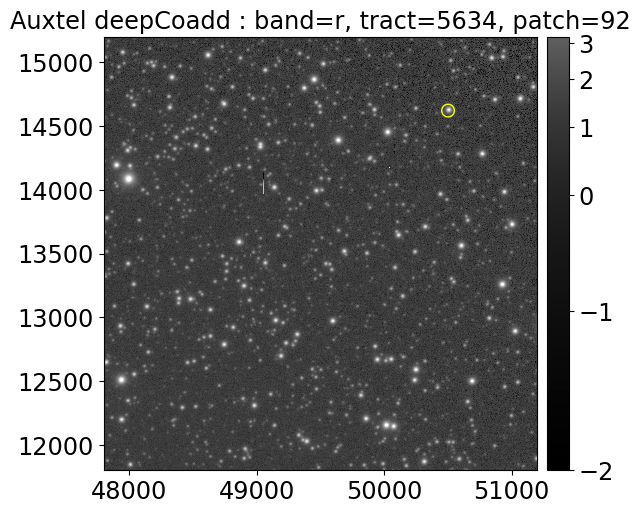

In [32]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image,title=the_title )

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')

plt.gca().axis('on')

#plt.scatter(pos_obj.x.values,pos_obj.y.values,marker="o",color="y")

(47799.5, 51199.5, 11799.5, 15199.5)

<Figure size 1200x1200 with 0 Axes>

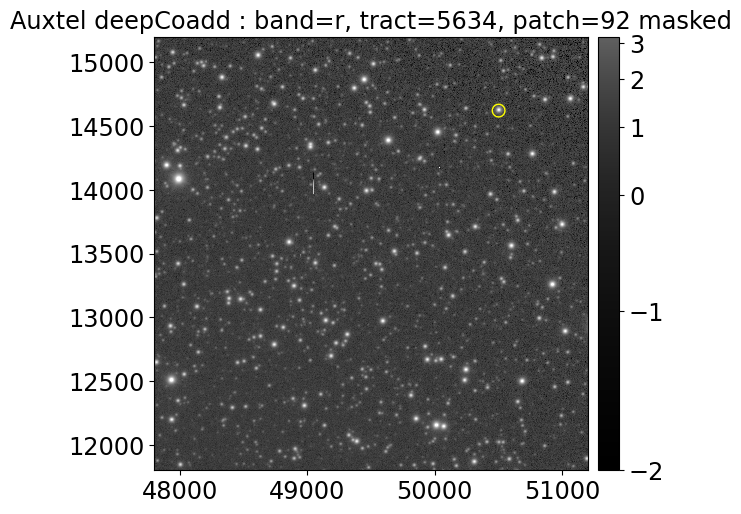

In [33]:
# Plot the calexp we just retrieved
plt.figure(figsize=(12,12))
afw_display = afwDisplay.Display(figsize=(12,12))
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.maskedImage.image,title=the_title+" masked")

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')


plt.gca().axis('on')

## Histo

Text(0.5, 1.0, 'Auxtel deepCoadd : band=r, tract=5634, patch=92')

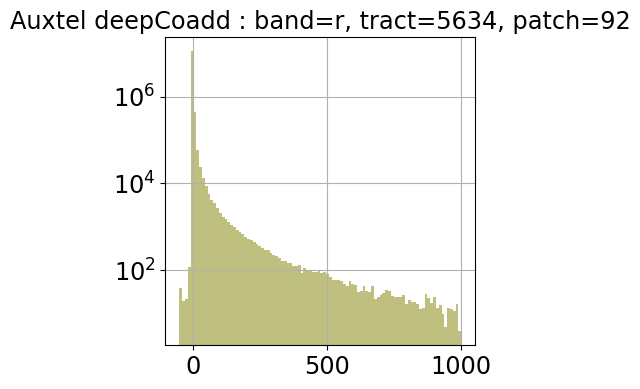

In [34]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
ax.hist(my_deepCoadd.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor='blue')
ax.hist(my_deepCoadd.maskedImage.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor="yellow")
ax.set_yscale('log')
ax.grid()
ax.set_title(the_title)